# **Modelo de Sistema de Recomendación - GRUPOREFERENCIA**
# **Algoritmo XGBClassifier**

In [1]:
import os
import psutil

# Memoria
print(f"Memoria total: {psutil.virtual_memory().total / 1e9:.2f} GB")  # Si muestra >16GB → probablemente remoto

# CPU
print(f"Núcleos lógicos: {os.cpu_count()}")  # >8 cores → servidor dedicado

Memoria total: 16.62 GB
Núcleos lógicos: 8


In [2]:
import pandas as pd
import numpy as np
import random
import joblib

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (f1_score,
                             matthews_corrcoef,
                             cohen_kappa_score)
from imblearn.over_sampling import BorderlineSMOTE
from xgboost import XGBClassifier

In [3]:
from dav_cas.tools.eva_mod import classification_report_df
from dav_cas.tools.graficos import conf_matrix_normalized_sn

In [4]:
# Semillas para reproducibilidad
SEED = 7
SEED_SPLIT = 7
os.environ['PYTHONHASHSEED'] = f'{SEED}'  # Para operaciones hash en Python
np.random.seed(SEED)                   # Semilla para numpy
random.seed(SEED)

In [5]:
basedir = os.getcwd()

## **1- Carga de los datos SB11_SBPro_UDENAR_02_01:**

## **(Data #8)**

In [6]:
# MEJOR DATA # 8
CAR_NOM = '02' # Características nominales
CAR_ORD = '01' # Características ordinales

In [7]:
X = pd.read_csv(os.path.join(basedir, f'data/data_icfes/SB11_SBPro/SB11_SBPro_UDENAR_{CAR_NOM}_{CAR_ORD}.csv'))

## **2- Carga los valores de 'y' (GRUPOREFERENCIA):**

In [8]:
y = pd.read_csv(os.path.join(basedir, 'data/data_icfes/SB11_SBPro/y_GRUPOREFERENCIA_clase.csv'))

## **3- Dividir el dataset en entrenamiento y prueba:**

In [9]:
# División estratificada en train (80%) y test (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=SEED_SPLIT)

## **4- Selección de Características:**

In [10]:
%run -i "Selección de características.ipynb"

In [11]:
dic_nom_features = {'00': nominal_features_00,
                    '01': nominal_features_01,
                    '02': nominal_features_02}

In [12]:
dic_ord_features = {'00': dic_car_ord_00,
                    '01': dic_car_ord_01,
                    '02': dic_car_ord_02}

In [13]:
# Características Nominales
nominal_features = dic_nom_features[CAR_NOM]
# Características Ordinales
ordinal_features = list(dic_ord_features[CAR_ORD].keys())
# Características Numéricas
numerical_features = numeric_features

## **5- Configuración del Preprocesamiento:**

In [14]:
preprocessor = ColumnTransformer(
    transformers=[
        # Codificar variables categóricas nominales
        ('nominal', OneHotEncoder(handle_unknown='ignore'), nominal_features),
        # Codificar variables categóricas ordinales
        ('ordinal', OrdinalEncoder(), ordinal_features),
        # Escalar variables numéricas
        ('numerico', RobustScaler(), numerical_features)
    ],
    remainder='drop'  # Descarta columnas no especificadas (opcional)
    # remainder='passthrough'  # Mantiene las columnas no especificadas
)

## **6- Configuración de Pipeline (Tuberías):**

#### **Configurar Stratified K-Fold (5 folds)**

StratifiedKFold para mantener la distribución de clases en cada fold HalvingGridSearchCV optimiza la búsqueda de hiperparámetros con eliminación competitiva

In [15]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

### Conteo de frecuencia por clase:

In [16]:
from collections import Counter

# Calcular el número mínimo de muestras en cualquier clase
class_counts = Counter(y_train["GRUPOREFERENCIA"].to_list())
min_samples = min(class_counts.values())

In [17]:
# Ajustar k_neighbors considerando los folds de CV (ej. para 5-fold CV)
n_splits = cv.get_n_splits()  # Obtener el número de folds
adjusted_min_samples = max(1, int(min_samples * (n_splits - 1) / n_splits))
safe_k = max(1, adjusted_min_samples - 1)  # Asegurar que k_neighbors <= n_muestras

In [18]:
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('blsmote', BorderlineSMOTE(
        sampling_strategy={cls: max(count, safe_k + 1) for cls, count in class_counts.items()},  # Mínimo safe_k + 1 muestras
        k_neighbors=safe_k,  # Usar el valor ajustado
        kind='borderline-1',
        random_state=SEED
    )),
    ('classifier', XGBClassifier(
        eval_metric='mlogloss',
        use_label_encoder=False,
        device='cpu',  # Asegurar uso de CPU
        n_estimators=800,
        tree_method='hist',  # Método compatible con CPU
        verbosity=0
    ))
])

## **7- Búsqueda de hiperparámetros:**

In [19]:
param_grid = {'classifier__objective': ['multi:softprob'],
              'classifier__max_depth': [3, 6, 9],
              'classifier__max_delta_step':[2, 5, 8, 10], # Set it to value of 1-10 might help control the update.
              'classifier__learning_rate': [0.1, 0.05, 0.01],
              'classifier__min_child_weight': [1, 5, 10, 12],
              'blsmote__k_neighbors': [3, 5],
              'blsmote__sampling_strategy': ['auto', {cls: max(count, safe_k + 1) for cls, count in class_counts.items()}],  # Control de sobremuestreo
              'classifier__subsample': [0.5, 0.8, 0.9, 1.0]
              }

## **8- Configuración de la búsqueda:**

In [20]:
search = HalvingGridSearchCV(
    pipeline,
    param_grid,
    resource='classifier__n_estimators',
    max_resources=300, # Equilibrio entre capacidad de encontrar óptimos y costo computacional
    factor=4,
    cv=cv,
    scoring='f1_macro',
    n_jobs=-1,
    random_state=SEED,
    aggressive_elimination=False,
    return_train_score=True,
    refit=True,
    verbose=0
)

## **9- Entrenamiento:**

In [21]:
%%time
search.fit(X_train, y_train["GRUPOREFERENCIA"].values)

CPU times: user 2min 1s, sys: 4.23 s, total: 2min 5s
Wall time: 26min 11s


HalvingGridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=7, shuffle=True),
                    estimator=Pipeline(steps=[('preprocessor',
                                               ColumnTransformer(transformers=[('nominal',
                                                                                OneHotEncoder(handle_unknown='ignore'),
                                                                                ['FAMI_TIENECOMPUTADOR',
                                                                                 'ESTU_GENERO',
                                                                                 'FAMI_TIENESERVICIOTV',
                                                                                 'FAMI_TIENEINTERNET',
                                                                                 'FAMI_TIENEHORNOMICROOGAS',
                                                                                 'FAMI_TIENELAVADORA']),
                                                                               ('ordinal',
                                                                                Ordi...
                                                                8: 205, 9: 1150,
                                                                10: 1447,
                                                                11: 92, 12: 192,
                                                                13: 46}],
                                'classifier__learning_rate': [0.1, 0.05, 0.01],
                                'classifier__max_delta_step': [2, 5, 8, 10],
                                'classifier__max_depth': [3, 6, 9],
                                'classifier__min_child_weight': [1, 5, 10, 12],
                                'classifier__objective': ['multi:softprob'],
                                'classifier__subsample': [0.5, 0.8, 0.9, 1.0]},
                    random_state=7, resource='classifier__n_estimators',
                    scoring='f1_macro')

In [22]:
joblib.dump(search, os.path.join(basedir, './models/best_model_XGBoostClassifier_search.pkl'))

['/home/jacques/Documentos/ml_study/FINALES/./models/best_model_XGBoostClassifier_search.pkl']

## **10- Resultados:**

In [23]:
print(f"Mejores parámetros: {search.best_params_}")
print(f"Mejor puntuación: {search.best_score_}")

Mejores parámetros: {'blsmote__k_neighbors': 3, 'blsmote__sampling_strategy': 'auto', 'classifier__learning_rate': 0.05, 'classifier__max_delta_step': 5, 'classifier__max_depth': 6, 'classifier__min_child_weight': 12, 'classifier__objective': 'multi:softprob', 'classifier__subsample': 0.5, 'classifier__n_estimators': 256}
Mejor puntuación: 0.1551552937954464


#### **Mejores parámetros del modelo:**

In [24]:
best_model = search.best_estimator_
modelo_inside = best_model.named_steps['classifier']
modelo_inside.get_params()

{'objective': 'multi:softprob',
 'base_score': None,
 'booster': None,
 'callbacks': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'device': 'cpu',
 'early_stopping_rounds': None,
 'enable_categorical': False,
 'eval_metric': 'mlogloss',
 'feature_types': None,
 'feature_weights': None,
 'gamma': None,
 'grow_policy': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': 0.05,
 'max_bin': None,
 'max_cat_threshold': None,
 'max_cat_to_onehot': None,
 'max_delta_step': 5,
 'max_depth': 6,
 'max_leaves': None,
 'min_child_weight': 12,
 'missing': nan,
 'monotone_constraints': None,
 'multi_strategy': None,
 'n_estimators': 256,
 'n_jobs': None,
 'num_parallel_tree': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'sampling_method': None,
 'scale_pos_weight': None,
 'subsample': 0.5,
 'tree_method': 'hist',
 'validate_parameters': None,
 'verbosity': 0,
 'use_label_encoder': False}

## **11- Evaluación final con Test:**

In [25]:
best_model = search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)

print(f"\nReporte de clasificación:")
classification_report_df(y_test, y_pred, precisión=4)

print(f"\nF1-score ma: {f1_score(y_test, y_pred, average='macro'):.4f}")

print(f"\nMatthews corr: {matthews_corrcoef(y_test, y_pred):.4f}")

print(f"\nCohen kappa: {cohen_kappa_score(y_test, y_pred):.4f}")


Reporte de clasificación:


,class,precision,recall,f1-score,support
0,0,0.2583,0.2153,0.2348,144
1,1,0.2273,0.1389,0.1724,36
2,2,0.1538,0.1053,0.1250,57
3,3,0.0893,0.0676,0.0769,74
4,4,0.0455,0.0233,0.0308,43
5,5,0.2059,0.1077,0.1414,65
6,6,0.1364,0.0682,0.0909,44
7,7,0.2655,0.3297,0.2941,91
8,8,0.2439,0.1961,0.2174,51
9,9,0.3499,0.4167,0.3803,288



F1-score ma: 0.1918

Matthews corr: 0.1710

Cohen kappa: 0.1701


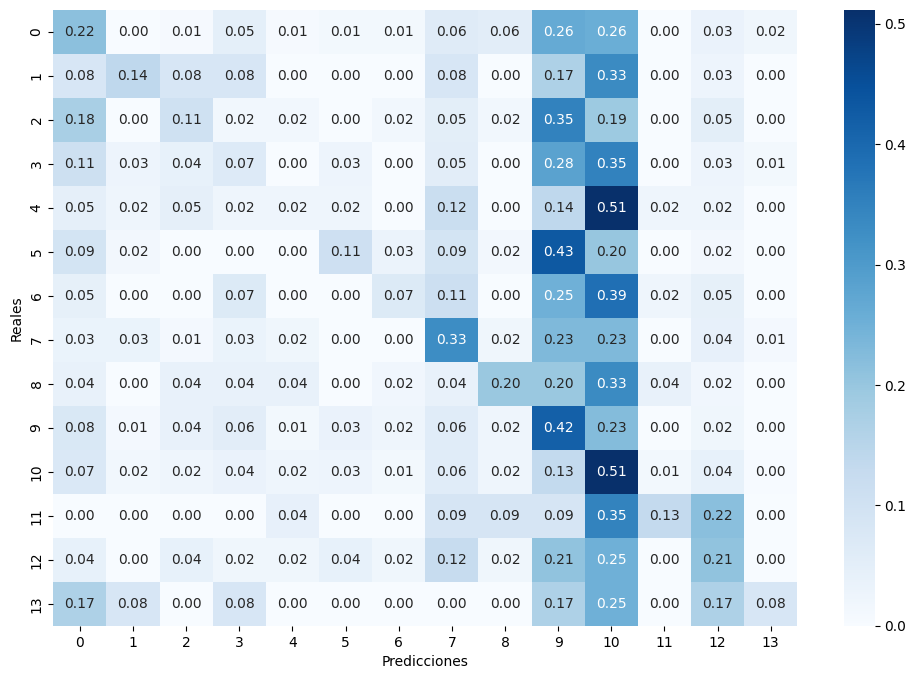

Matriz de Confusión Normalizada (por fila)
Modelo XGBClassifier (GRUPOREFERENCIA)


In [26]:
conf_matrix_normalized_sn(y_test, y_pred)
print("Matriz de Confusión Normalizada (por fila)\nModelo XGBClassifier (GRUPOREFERENCIA)")

## **12- Entrenamiento final con todos los datos X:**

In [27]:
from sklearn.base import clone

best_model = search.best_estimator_

# Reentrenar con TODOS los datos (train + test)
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

final_model = clone(best_model)
final_model.fit(X_full, y_full["GRUPOREFERENCIA"].values)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('nominal',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['FAMI_TIENECOMPUTADOR',
                                                   'ESTU_GENERO',
                                                   'FAMI_TIENESERVICIOTV',
                                                   'FAMI_TIENEINTERNET',
                                                   'FAMI_TIENEHORNOMICROOGAS',
                                                   'FAMI_TIENELAVADORA']),
                                                 ('ordinal', OrdinalEncoder(),
                                                  ['FAMI_ESTRATOVIVIENDA',
                                                   'FAMI_EDUCACIONPADRE',
                                                   'FAMI_EDUCACIONMADRE',
                                                   'FAMI_PE...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=5,
                               max_depth=6, max_leaves=None,
                               min_child_weight=12, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=256, n_jobs=None,
                               num_parallel_tree=None, ...))])

## **14- Guardar modelo final:**

In [28]:
joblib.dump(final_model, os.path.join(basedir, './models/best_model_XGBoostClassifier_final.pkl'))

['/home/jacques/Documentos/ml_study/FINALES/./models/best_model_XGBoostClassifier_final.pkl']

## **15- Predicción con el modelo final:**

In [29]:
X_test.iloc[7:8]

,FAMI_TIENECOMPUTADOR,ESTU_GENERO,FAMI_TIENESERVICIOTV,FAMI_TIENEINTERNET,FAMI_TIENEHORNOMICROOGAS,FAMI_TIENELAVADORA,FAMI_ESTRATOVIVIENDA,FAMI_EDUCACIONPADRE,FAMI_EDUCACIONMADRE,FAMI_PERSONASHOGAR,EDAD,LAT_COLE,LON_COLE,PUNT_LECTURA_CRITICA,PUNT_MATEMATICAS,PUNT_SOCIALES_CIUDADANAS,PUNT_C_NATURALES,PUNT_INGLES
579,NO,F,NO,NO,NO,NO,SIN ESTRATO O ESTRATO 1,SECUNDARIA (BACHILLERATO) INCOMPLETA O COMPLETA,"NO SABE, NINGUNA O HASTA PRIMARIA INCOMPLETA O COMPLETA",1 A 4,16.0,0.829022,-77.629513,55.0,67.0,64.0,63.0,49.0


In [30]:
model = joblib.load(os.path.join(basedir, './models/best_model_XGBoostClassifier_final.pkl'))
model.predict(X_test.iloc[7:8])

array([10])